# Training a Convolutional Neural Network for Kidney Stones Object Detection

In [1]:
%pip install tabulate tensorflow numpy opencv-python matplotlib pandas

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tabulate in c:\users\brian\onedrive - university of witwatersrand\desktop\off_the_grid\projects\ebook_object_detection\.venv\lib\site-packages (0.9.0)
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached absl_py-2.2.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.w

## Import Libraries

In [63]:
import os
from tabulate import tabulate
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

## Load Images and Labels

In [64]:
# Directory paths for the train, validation, and test sets
# Define the path to the data directory
data_dir = 'data'
sets = ['train', 'valid', 'test']  # Corrected to match your sets

# Function to load image and label paths
def load_data(img_dir, lbl_dir):
    img_paths = []
    lbl_paths = []
    for img_file in os.listdir(img_dir):
        img_paths.append(os.path.join(img_dir, img_file))
        lbl_paths.append(os.path.join(lbl_dir, img_file.replace('.jpg', '.txt')))
    return img_paths, lbl_paths

# Dictionary to store image and label paths for each set
data_paths = {}

# Loop through each set and load the data paths
for set_name in sets:
    img_dir = os.path.join(data_dir, set_name, 'images')
    lbl_dir = os.path.join(data_dir, set_name, 'labels')
    
    img_paths, lbl_paths = load_data(img_dir, lbl_dir)
    data_paths[set_name] = {'img_paths': img_paths, 'lbl_paths': lbl_paths}

# Accessing paths for each set
train_img_paths, train_lbl_paths = data_paths['train']['img_paths'], data_paths['train']['lbl_paths']
val_img_paths, val_lbl_paths = data_paths['valid']['img_paths'], data_paths['valid']['lbl_paths']
test_img_paths, test_lbl_paths = data_paths['test']['img_paths'], data_paths['test']['lbl_paths']

### Data Split

In [65]:
# Initialize a summary list to store the data for tabulation
data_summary = [
    ["Train", len(train_img_paths), len(train_lbl_paths)],
    ["Test", len(test_img_paths), len(test_lbl_paths)],
    ["Validate", len(val_img_paths), len(val_lbl_paths)]
]

# Define the table headers
headers = ["Dataset", "Number of Images", "Number of Labels"]

# Print the table
print(tabulate(data_summary, headers=headers, tablefmt="grid"))

+-----------+--------------------+--------------------+
| Dataset   |   Number of Images |   Number of Labels |
+===========+====================+====================+
| Train     |               1054 |               1054 |
+-----------+--------------------+--------------------+
| Test      |                123 |                123 |
+-----------+--------------------+--------------------+
| Validate  |                123 |                123 |
+-----------+--------------------+--------------------+


### Parse Annotations

In [66]:
import pandas as pd

# Function to parse YOLO label files
def parse_yolo_label(label_path, img_width, img_height):
    """ Reads YOLO label file and converts to normalized format """
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, width, height = map(float, data[1:])

            # Convert from YOLO format (normalized) to pixel coordinates
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)

            boxes.append([class_id, x_min, y_min, x_max, y_max])
    return boxes

# Function to load images and corresponding labels
def load_dataset(img_paths, lbl_paths, img_size=(224, 224)):
    images = []
    labels = []
    
    for img_path, lbl_path in zip(img_paths, lbl_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)  # Resize for CNN
        
        # Read image size for bbox conversion
        img_h, img_w, _ = img.shape
        bboxes = parse_yolo_label(lbl_path, img_w, img_h)
        
        images.append(img)
        labels.append(bboxes)

    return np.array(images), labels

# Load train, validation, and test sets
train_images, train_labels = load_dataset(train_img_paths, train_lbl_paths)
val_images, val_labels = load_dataset(val_img_paths, val_lbl_paths)
test_images, test_labels = load_dataset(test_img_paths, test_lbl_paths)

print("Train images shape:", train_images.shape)
print("Number of train labels:", len(train_labels))


Train images shape: (1054, 224, 224, 3)
Number of train labels: 1054


### Visualize Some Annotations

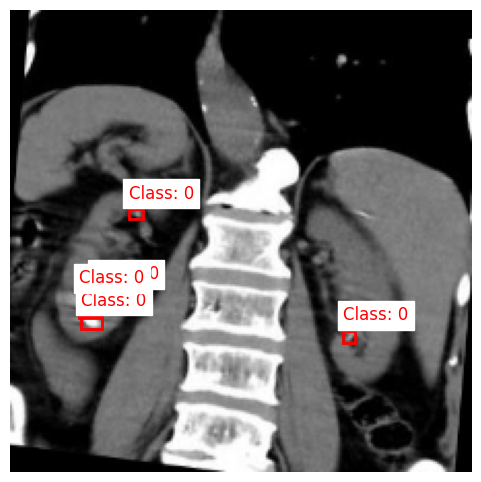

In [67]:
import random

def plot_image_with_bboxes(images, labels, index=None):
    """
    Plots an image with its bounding box annotations.
    :param images: List or numpy array of images
    :param labels: List of bounding box annotations (format: [class_id, x_min, y_min, x_max, y_max])
    :param index: Optional index to select a specific image; if None, a random image is chosen.
    """
    if index is None:
        index = random.randint(0, len(images) - 1)

    image = images[index]
    bboxes = labels[index]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    
    for bbox in bboxes:
        class_id, x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        plt.gca().add_patch(rect)
        plt.text(x_min, y_min - 5, f'Class: {class_id}', color='red', fontsize=12, backgroundcolor='white')

    plt.axis("off")
    plt.show()

# Plot a random image with annotations
plot_image_with_bboxes(train_images, train_labels)


## Normalize Bounding Boxes

In [68]:
def normalize_bboxes(labels, img_width, img_height):
    """ Normalize bounding box coordinates to range [0,1] """
    normalized_labels = []
    for bboxes in labels:
        norm_bboxes = []
        for bbox in bboxes:
            class_id, x_min, y_min, x_max, y_max = bbox
            norm_bboxes.append([
                class_id,
                x_min / img_width,
                y_min / img_height,
                x_max / img_width,
                y_max / img_height
            ])
        normalized_labels.append(norm_bboxes)
    return normalized_labels

# Normalize train, val, and test labels
train_labels_norm = normalize_bboxes(train_labels, 224, 224)
val_labels_norm = normalize_bboxes(val_labels, 224, 224)
test_labels_norm = normalize_bboxes(test_labels, 224, 224)

## Convert Labels to Fixed-Size Arrays

In [69]:
def format_labels(labels, max_objects=5):
    """ Converts variable-length bbox lists to fixed-length numpy arrays """
    formatted_labels = np.zeros((len(labels), max_objects, 5))  # (N, max_objects, 5)
    
    for i, bboxes in enumerate(labels):
        for j, bbox in enumerate(bboxes[:max_objects]):  # Limit to max_objects
            formatted_labels[i, j] = bbox  # Store [class_id, x_min, y_min, x_max, y_max]

    return formatted_labels

# Convert labels
train_labels_array = format_labels(train_labels_norm)
val_labels_array = format_labels(val_labels_norm)
test_labels_array = format_labels(test_labels_norm)

print("Train labels shape:", train_labels_array.shape)  # (num_images, max_objects, 5)

Train labels shape: (1054, 5, 5)


## Define the CNN Model

In [70]:
import tensorflow.keras.backend as K

def iou_loss(y_true, y_pred):
    """ IoU loss for bounding box regression """
    x_min_true, y_min_true, x_max_true, y_max_true = tf.split(y_true[..., 1:], 4, axis=-1)
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = tf.split(y_pred[..., 1:], 4, axis=-1)

    inter_xmin = K.maximum(x_min_true, x_min_pred)
    inter_ymin = K.maximum(y_min_true, y_min_pred)
    inter_xmax = K.minimum(x_max_true, x_max_pred)
    inter_ymax = K.minimum(y_max_true, y_max_pred)

    inter_area = K.maximum(0.0, inter_xmax - inter_xmin) * K.maximum(0.0, inter_ymax - inter_ymin)
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)

    union_area = true_area + pred_area - inter_area
    iou = inter_area / K.maximum(union_area, K.epsilon())

    return 1 - iou  # IoU loss


In [71]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define input shape
input_shape = (224, 224, 3)
max_objects = 5  # Maximum objects per image
num_outputs = max_objects * 5  # 5 values per object (class_id, x_min, y_min, x_max, y_max)

# Build the CNN Model
inputs = Input(shape=input_shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_outputs, activation='sigmoid')(x)  # Output bounding boxes (normalized)

# Define model
model = Model(inputs=inputs, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=iou_loss,
              metrics=['mae'])

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,611,737 (196.88 MB)

 Trainable params: 51,611,737 (196.88 MB)

 Non-trainable params: 0 (0.00 B)

## Reshape Labels for Training 

In [72]:
# Reshape labels to match model output
train_labels_flat = train_labels_array.reshape(len(train_labels_array), -1)
val_labels_flat = val_labels_array.reshape(len(val_labels_array), -1)

## Train the Model

In [73]:
# Train the model
history = model.fit(
    train_images, train_labels_flat,
    validation_data=(val_images, val_labels_flat),
    epochs=10, 
    batch_size=16
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 920ms/step - loss: 1.0000 - mae: 0.5093 - val_loss: 1.0000 - val_mae: 0.5310
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 644ms/step - loss: 1.0000 - mae: 0.4913 - val_loss: 1.0000 - val_mae: 0.5310
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 627ms/step - loss: 0.9999 - mae: 0.4909 - val_loss: 1.0000 - val_mae: 0.5310
Epoch 4/10
27/66 ━━━━━━━━━━━━━━━━━━━━ 23s 602ms/step - loss: 1.0000 - mae: 0.4917

KeyboardInterrupt: 

In [ ]:
# Reshape test labels to match model output
test_labels_flat = test_labels_array.reshape(len(test_labels_array), -1)

# Evaluate the model
loss, mae = model.evaluate(test_images, test_labels_flat)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.1540 - mae: 0.2119
Test Loss: 0.1536, Test MAE: 0.2092


In [ ]:
def denormalize_bboxes(bboxes, img_width, img_height):
    """ Convert normalized coordinates back to pixel values """
    denorm_bboxes = []
    for bbox in bboxes:
        class_id = int(bbox[0])  # Class ID remains unchanged
        x_min = int(bbox[1] * img_width)
        y_min = int(bbox[2] * img_height)
        x_max = int(bbox[3] * img_width)
        y_max = int(bbox[4] * img_height)
        denorm_bboxes.append([class_id, x_min, y_min, x_max, y_max])
    return denorm_bboxes


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


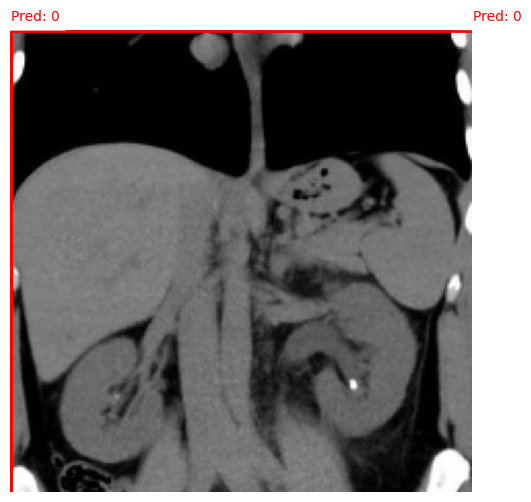

In [ ]:
import random

def plot_prediction(index=None):
    """
    Plots a test image with its true and predicted bounding boxes.
    :param index: Index of the test image (random if None).
    """
    if index is None:
        index = random.randint(0, len(test_images) - 1)

    image = test_images[index]
    true_bboxes = test_labels_array[index]
    pred_bboxes = model.predict(test_images[index:index+1]).reshape(max_objects, 5)

    # Convert bounding boxes from normalized to pixel values
    true_bboxes = denormalize_bboxes(true_bboxes, 224, 224)
    pred_bboxes = denormalize_bboxes(pred_bboxes, 224, 224)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Draw ground truth boxes in **green**
    for bbox in true_bboxes:
        class_id, x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='green', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x_min, y_min - 5, f'GT: {class_id}', color='green', fontsize=10, backgroundcolor='white')

    # Draw predicted boxes in **red**
    for bbox in pred_bboxes:
        class_id, x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x_min, y_min - 5, f'Pred: {class_id}', color='red', fontsize=10, backgroundcolor='white')

    plt.axis("off")
    plt.show()

# Plot a random prediction
plot_prediction()


In [ ]:
# Check some random predictions before training
sample_preds = model.predict(train_images[:5])
print("Sample predictions before training:", sample_preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Sample predictions before training: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]]
